## Challenge: Feature Selection / Prepare a dataset for modeling

Working through the stages of model preparation, do the following:  

- Using a dataset of your choice, select an outcome variable, pick four or five  variables to act as the basis for features. 
 
- Explore the variables using the univariate and bivariate methods you've learned so far.

- Create ten new features. Explain the reasoning behind each one.

- Using filtering methods, select the five best features and justify your choices.


## New features summary

Created 10 new features: 

1. 'CtoC': transaction from a customer to a customer (1) or customer to merchant (0). 
    - All fraud transactions are from Customer to customer. No Merchant-initiated or merchant-received transactions are fraud. 

2. 'zeroAmount': transaction amount is zero (1) or not (0). 
    - All zero amount transactions are fraud transactions 

3. 'origBalanceMatch': difference in the old and new balance of the origin account matches with the amount of transaction (1) or not (0) 

4. 'destBalanceMatch': difference in the old and new balance of the destination account matches with with the amount of transaction (1) or not (0).

5. 'amount75k+': Transaction amount more than 75k (1) or not (0)
    - fraudulent amounts are around 75000 whereas non-fraudulent amounts are around 26000. There are 6805 fraud cases where the amount is more than 75k, and only 1408 where the amount in <75k. 
    
6. 'day': dividing steps in days

7. 'hour': dividing steps into hours 

8. 'transferPercent': to find out what % of amount the fraudsters transfer for each fraud transaction

9. 'transfer_all': if transferPercent is 1 (1) or not (0)
    - In fraudulent cases, almost all transaction amount are 100% of the original balance indicating that the fraudster empties the bank account in most fraudulent cases. In non-fraudulent cases, the transaction amount percentage varies widely. 

10. 'oldBalanceQtl': quantiles of the originating balannce to see if they are prone to fraud transactions 



In [174]:
# data with new features
data_new.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,CtoC,zeroAmount,origBalanceMatch,destBalanceMatch,amount75k+,day,hour,transferPercent,transferAll,oldBalanceQtl
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,0,0,0,-9839,0,0,1,0.0578,0,4.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,0,0,0,-1864,0,0,1,0.0877,0,3.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,1,0,0,-181,0,0,1,1.0000,1,2.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,1,0,0,21001,0,0,1,1.0000,1,2.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,0,0,0,-11668,0,0,1,0.2808,0,3.0


In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing 

In [102]:
#data1 = data.iloc[:3181300]
#data1.to_csv("paysimhf.csv")
# Original "paysim.csv" data 6.36M entries,"paysimhf.csv" containts about 3.18 mln entries

# data found here - https://www.kaggle.com/ntnu-testimon/paysim1/home
# thesis - http://bth.diva-portal.org/smash/record.jsf?pid=diva2%3A955852&dswid=-8842

data = pd.read_csv("paysim.csv")   #, index_col=0 #tried index_col because the paysimhf was reading index as one column )
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [103]:
#renaming some column names for PEP8 conventions

data = data.rename(columns={'oldbalanceOrg' : 'oldBalanceOrig', 'newbalanceOrig': 'newBalanceOrig', \
                            'oldbalanceDest': 'oldBalanceDest', 'newbalanceDest': 'newBalanceDest'})
data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [104]:
# Check null values 

data.isnull().values.any()

False

In [105]:
#data.info()

In [106]:
#data1 = data.iloc[:1000000]

## selecting a subset for steps 1-12, indicating transaction within the first 12 hours 
#data12 = data.loc[lambda df: df.step <= 12]

## selecting a range of features for steps 1-12, indicating transaction within the first 12 hours.   
#df = data.loc[lambda df: df.step <= 12, 
#    ['step','type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']
#]

In [107]:
## Transforming qualitative values of variable 'type' to numerical ones

#type_num = pd.Series(sorted(df['type'].unique())).to_dict()
#num_values = dict([(value,key) for key,value in type_num.items()])
#print(num_values)

#df['type'] = df['type'].map(num_values)
#print(df.type.value_counts())

## Data exploration (EDA) 

### Dataset description 

The Mobile Money Payment Simulation case study is based on a real company that has developed a mobile money transaction implementation providing mobile phone users the ability to transfer money between themselves using the phone as a sort of electronic wallet. There are 6362619 datapoints. 

### Attribute description

There are 11 attributes as follows:

- Categorical variables:
    - 'type': 4 values - CASH-IN, CASH-OUT, PAYMENT, TRANSFER
        - CASH-IN is the process of increasing the balance of account by paying in cash to a merchant.
        - CASH-OUT is the opposite process of CASH-IN, it means to withdraw cash from a merchant which decreases the balance of the account.
        - DEBIT is similar process than CASH-OUT and involves sending the money from the mobile money service to a bank account.
        - PAYMENT is the process of paying for goods or services to merchants which decreases the balance of the account and increases the balance of the receiver.
        - TRANSFER is the process of sending money to another user of the service through the mobile money platform

    - 'isFraud', **outcome variable**; identifies a fraudulent transaction (1) and non fraudulent (0)
    - isFlaggedFraud: flags illegal attempts to transfer more than 200,000 in a single transaction; values: 0,1
            
           
- Continuous variables: 
    - 'step': 1 - 743; Maps a unit of time in the real world. In this case 1 step is 1 hour of time.
    - 'amount': amount of the transaction in local currency
    - 'oldBalanceOrig': initial balance before the transaction
    - 'newBalanceOrig':  customer's balance after the transaction.
    - 'oldBalanceDest': initial recipient balance before the transaction.
    - 'newBalanceDest':  recipient's balance after the transaction.
    - isFraud:

        
* Do any of the variables have a known probability distribution (normal, Poisson, Gamma, etc)?
    - Not sure 
        
* Do I have missing data? If so, how much?  
    - no null values 

* How much variance is there in each of my variables?
    - 'amount', 'oldBalanceOrig' and 'newBalanceOrig' have the higher standard deviations

In [108]:
data.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [109]:
#df.iloc[:,:].isnull().sum()   #to see if there is any missing values in the whole datasset

#plt.hist(data.newbalanceDest)
#data.groupby('isFraud').newbalanceDest.plot(kind='hist')
#plt.legend()

In [110]:
# Checking the distribution of the types of transactions

print("--> Types of transactions: \n{}".format(data.type.value_counts()))
print("--> Fraud count: \n{}".format(data.isFraud.value_counts()))
print("--> Fraud %: {}".format(8213/(6354407+8213)))


--> Types of transactions: 
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
--> Fraud count: 
0    6354407
1       8213
Name: isFraud, dtype: int64
--> Fraud %: 0.001290820448180152


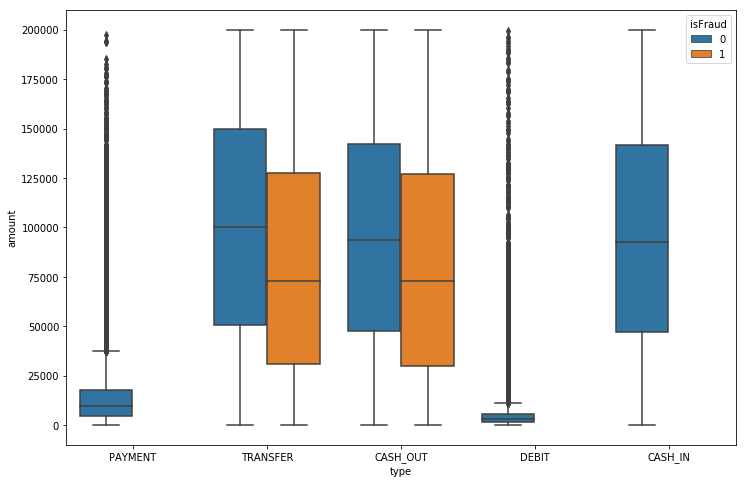

In [111]:
# Fradulent transactions per transaction type  
plt.figure(figsize=(12,8))
sns.boxplot(x = 'type', y = 'amount', hue = 'isFraud', data = data[data.amount < 2e5]) #amounts >2e5 are tagged as isFlaggedFraud, hence excluded

# --> looks like TRANSFER and CASH_OUT are most fraudulent transactions 

In [112]:
print("In fact, fraudulent transactions are found only in {}".format(data[data.isFraud ==1].type.unique()))
print("However, transactions tagged as fraud are found only in the variable 'isFlaggedFraud': {}".format(data[data.isFlaggedFraud == 1].type.unique()))

In fact, fraudulent transactions are found only in ['TRANSFER' 'CASH_OUT']
However, transactions tagged as fraud are found only in the variable 'isFlaggedFraud': ['TRANSFER']


Among the types of transaction, fraud transactions are found only in 'CASH_OUT' and 'TRANSFER'. However, the explanatory variable 'isFlaggedFraud' only marks 'TRANSFER' transactions are marked as fraud. Thus, 'isFlaggedFraud' might not be a good indicator variable. Let's take a look into its prediction and accuracy patterns. 


In [113]:
TP = data[(data.isFlaggedFraud == 1) & (data.isFraud == 1)].isFraud.value_counts()  #True positive - 16

In [114]:
TN = data[(data.isFlaggedFraud == 0) & (data.isFraud == 0)].isFraud.value_counts()   #True negative  6354407

In [115]:
FN = data[(data.isFlaggedFraud == 0) & (data.isFraud == 1)].isFraud.value_counts()  #False negative 8197

In [116]:
FP = data[(data.isFlaggedFraud == 1) & (data.isFraud == 0)].isFraud.value_counts()   # False positive 0 

In [117]:
print("\nTP: {} \t FP: 0 \t\nFN: {}  TN: {}".format(TP[1], FN[1], TN[0]))


TP: 16 	 FP: 0 	
FN: 8197  TN: 6354407


Therefore, we need to find other features that could be more indicative of the outcome variable. Let's take a look into the types of merchants in the dataset.

In [118]:
# Creating a subset "cc" to see how the customers and merchants match up 
cc = data[['nameOrig', 'nameDest', 'isFraud']]
cc['match'] = np.where(cc.nameOrig.str.contains('C') & cc.nameDest.str.contains('C'), 1, 0)
cc.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,nameOrig,nameDest,isFraud,match
0,C1231006815,M1979787155,0,0
1,C1666544295,M2044282225,0,0
2,C1305486145,C553264065,1,1
3,C840083671,C38997010,1,1
4,C2048537720,M1230701703,0,0


In [119]:
cc.nameOrig.str.contains('M').value_counts()
cc.nameDest.str.contains('M').value_counts()

False    4211125
True     2151495
Name: nameDest, dtype: int64

In [120]:
print(cc[cc.isFraud ==1].match.value_counts())  #Fraud and C-C transaction - 8213
print(cc[cc.isFraud ==0].match.value_counts())  #Not Fraud and C-C transaction - 4202912, and C-M 2151495 
print("All fraud transactions are C-to-C transactions and there are no merchant-initiated frauds.")

1    8213
Name: match, dtype: int64
1    4202912
0    2151495
Name: match, dtype: int64
All fraud transactions are C-to-C transactions and there are no merchant-initiated frauds.


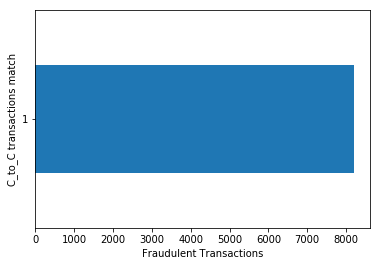

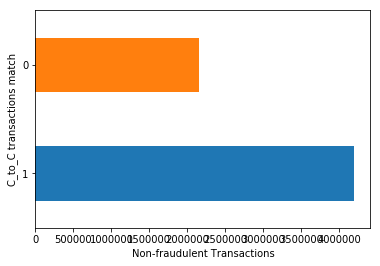

In [121]:
cc[cc.isFraud ==1].match.value_counts().plot(kind='barh')
plt.xlabel("Fraudulent Transactions")
plt.ylabel("C_to_C transactions match")
plt.show()

cc[cc.isFraud ==0].match.value_counts().plot(kind='barh')
plt.xlabel("Non-fraudulent Transactions")
plt.ylabel("C_to_C transactions match")
plt.show()

In [122]:
cc[cc.isFraud ==1].nameOrig.str.contains('M').value_counts() #no fraud transaction is initiated by a merchant
cc[cc.isFraud == 1].nameOrig.str.contains('C').value_counts() #8213 - all fraud transactions are initiated by a customer

cc[cc.isFraud ==1].nameDest.str.contains('M').value_counts() #no fraud transaction recipient is a merchant
cc[cc.isFraud == 1].nameDest.str.contains('C').value_counts() #8213 - all fraud transactions recipients are a customer


True    8213
Name: nameDest, dtype: int64

In [123]:
# Since all C-C transactions are fraud, it could be a good indicator of fraud transactions, however note that there is 
# a large number of non-fraudulent C-C transaction. 

# New Feature 1 - whether transaction is from a customer to a customer. 

data['CtoC'] = np.where(data.nameOrig.str.contains('C') & data.nameDest.str.contains('C'), 1, 0)

In [124]:
#data.head()

Additionally, the variable 'isFlaggedFraud' is described as flagging any TRANSFER amount over 200,000 as fraud. However there are only 16 such transactions with amount more than .2 million that have been flagged as fraud and are actually fraud. On the other hand, transfer amount that are over 200,000 and NOT flagged as fraud BUT are ACTUALLY fraud are 2724. There must be other criteria for flagging fraud. 

In [125]:
#Transfer amount more than 2e5, is flagged fraud and actually fraud are :
data[(data.isFlaggedFraud ==1) & (data.amount > 2e5) & (data.type == 'TRANSFER')].isFraud.value_counts()

1    16
Name: isFraud, dtype: int64

In [126]:
data[(data.isFlaggedFraud == 0) & (data.type == 'TRANSFER') & (data.amount > 2e5)].isFraud.value_counts()

0    406370
1      2724
Name: isFraud, dtype: int64

In [127]:
#data[(data.isFlaggedFraud == 0) & (data.isFraud == 1)].isFraud.value_counts()
#data[(data.isFlaggedFraud == 1) & (data.isFraud == 0)].isFraud.value_counts()

In [128]:
# We also see that any transaction of zero amount is generally a fraud. 
data[data.amount == 0]  # all 0 amounts are fraud and the balances do not change 

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,CtoC
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0,1
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0,1
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0,1
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0,1
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0,1
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0,1
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0,1
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0,1
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0,1
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0,1


In [129]:
# New feature 2: zeroAmount, if the amount is zero

data['zeroAmount'] = np.where(data.amount == 0, 1, 0)

#data.head()

In [130]:
# Where is the money going? 
# In all these cases, the original and destination new balance are 0 --> this is interesting 

data[(data.isFraud == 0) & (data.type == 'TRANSFER')].head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,CtoC,zeroAmount
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0,1,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0,1,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.00,8383.29,0,0,1,0
78,1,TRANSFER,42712.39,C283039401,10363.39,0.0,C1330106945,57901.66,24044.18,0,0,1,0
79,1,TRANSFER,77957.68,C207471778,0.00,0.0,C1761291320,94900.00,22233.65,0,0,1,0


In [131]:
# However, with absolute value we see that the calculations match with a few miscalculations 

origBalanceMatch = (abs(data.oldBalanceOrig - data.newBalanceOrig) - data.amount).astype(int)


Text(0.5,0,'original balance match before and after transaction')

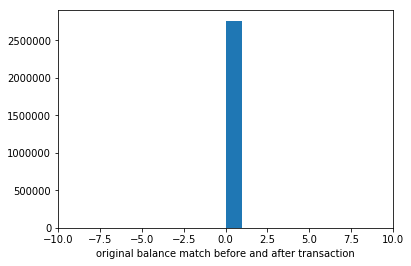

In [132]:
plt.hist(origBalanceMatch, bins=np.arange(0,10))
plt.xlim(-10, 10)
plt.xlabel("original balance match before and after transaction")

In [133]:
# New feature 3: origBalanceMatch, where the absolute values of the difference in the old and new balance match with the amount of transaction 

data['origBalanceMatch']= origBalanceMatch

In [134]:
# Similarly destination balance match. 

destBalanceMatch = (abs(data.oldBalanceDest - data.newBalanceDest) - data.amount).astype(int)

(-10, 10)

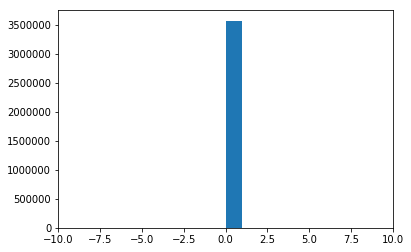

In [135]:
plt.hist(destBalanceMatch, bins=np.arange(0,10))
plt.xlim(-10,10)

In [136]:
# New feature 4: destBalanceMatch, balance calculatation after receiving transaction at the destination folder  
data['destBalanceMatch'] = destBalanceMatch

In [137]:
data.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud,CtoC,zeroAmount,origBalanceMatch,destBalanceMatch
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,0,0,-9839
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,0,0,-1864
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0,0,-181
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0,0,21001
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,0,0,-11668


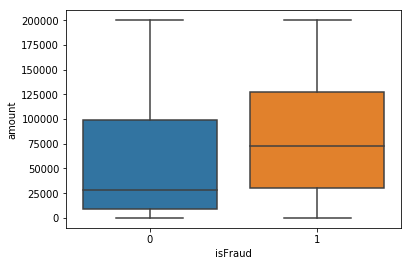

In [138]:
# Within the limits of 200,000, average fraudulent amounts are much higher than actual transactions. 
# From the boxplots, it seems fraudulent amounts are around 75000 whereas non-fraudulent amounts are around 26000. 

sns.boxplot(x='isFraud', y='amount', data=data[data.amount < 2e5])

In [139]:
# And, accordingly, there are 6805 fraud transactions when the transaction amount is more than 75000. 
# There are only 1408 fraud transactions when the amount is lower than 75000

data[data.amount >= 75e3].isFraud.value_counts()  #6805

0    3172768
1       6805
Name: isFraud, dtype: int64

In [140]:
# New feature 5: amount75k and plus

data['amount75k+'] = np.where(data.amount >= 75e3, 1, 0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


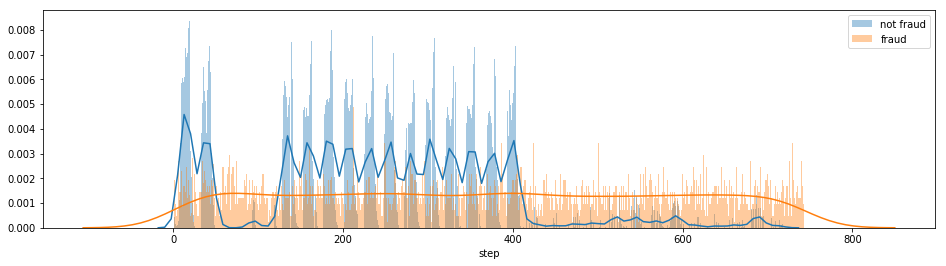

In [141]:
# When does the fraud take place? 

plt.figure(figsize =(16,4))
sns.distplot(data[data['isFraud'] ==0].step, bins= 743, norm_hist=True, label='not fraud')
sns.distplot(data[data['isFraud'] ==1].step, bins=743, norm_hist=True, label='fraud')
plt.legend()
plt.show()

# --> looks like there is a recurrent/ cyclic pattern in actual transactions while fraudulent transactions have no pattern

In [142]:
# New features 6 & 7: dividing steps into days and hours

data['day'] = (data.step/24).astype(int)  #dividing steps into days

data['hour'] = data.step%24  #dividing steps into hours

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


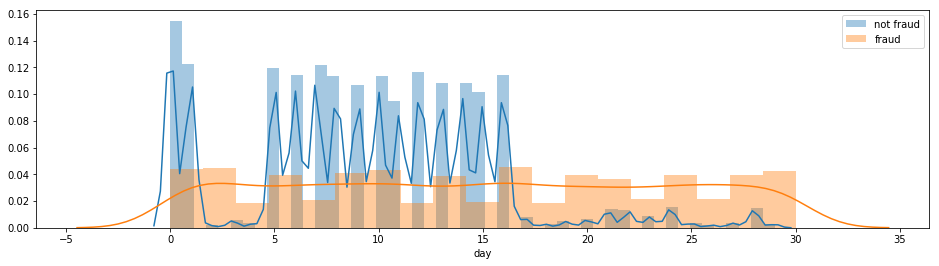

In [143]:
plt.figure(figsize =(16,4))
sns.distplot(data[data['isFraud'] ==0].day, label='not fraud')
sns.distplot(data[data['isFraud'] ==1].day, label='fraud')
plt.legend()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


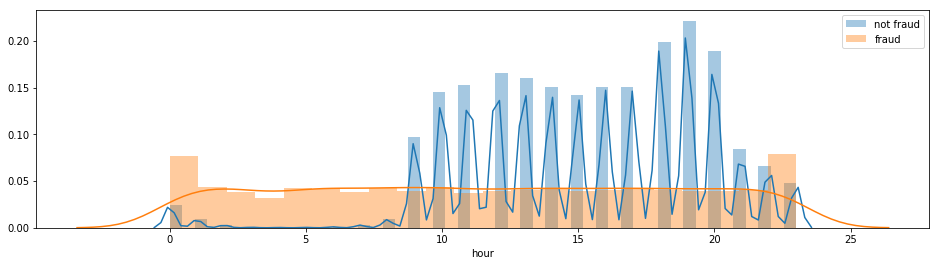

In [144]:
plt.figure(figsize =(16,4))
sns.distplot(data[data['isFraud'] ==0].hour, label='not fraud')
sns.distplot(data[data['isFraud'] ==1].hour, label='fraud')
plt.legend()
plt.show()


Fraudulent transactions happen throughout the day and throughout the month without any pattern. Non-fraudulent transactions, on the other hand, seem to be more conditioned and systematic. Non-fraudulent transactions are common in the first half of the month and is probably correlated with paycheck issue. Similarly, more actual transactions happen during the waking hours (e.g., 9 am - 8 pm) in a day. 


In [145]:
# New feature 8: transferPercent - to find out what % of amount the fraudsters transfer for each fraud transaction 

transferPercent = data.amount / data.oldBalanceOrig

In [146]:
transferPercent = np.round(transferPercent, 4)
transferPercent.describe()

count    6.362604e+06
mean              inf
std               NaN
min      0.000000e+00
25%      2.344000e-01
50%      6.458600e+00
75%               inf
max               inf
dtype: float64

In [147]:
#np.isinf(transferPercent).value_counts()

In [148]:
data['transferPercent'] = transferPercent

In [149]:
#data.loc[~np.isfinite(data['transferPercent']), 'transferPercent'] = np.nan   # replacing 'inf' values as NaN
#or data.loc[np.isinf(data['transferPercent']), ...] 

In [150]:
data.loc[np.isinf(data['transferPercent']), 'transferPercent'] = 0

In [151]:
print(data[data.isFraud == 0].transferPercent.describe())
print(data[data.isFraud == 1].transferPercent.describe())


count    6.354407e+06
mean     8.181779e+01
std      3.397898e+03
min      0.000000e+00
25%      0.000000e+00
50%      7.610000e-02
75%      2.228800e+00
max      3.925476e+06
Name: transferPercent, dtype: float64
count    8197.000000
mean        0.995719
std         0.388660
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        29.526600
Name: transferPercent, dtype: float64


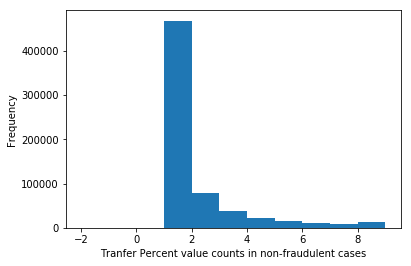

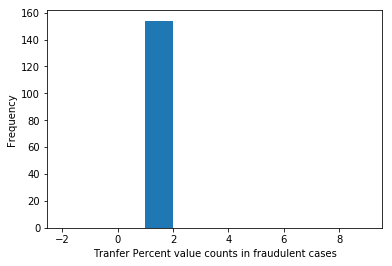

In [152]:
data[data.isFraud == 0].transferPercent.value_counts().plot(kind='hist', bins=np.arange(-2,10))
plt.xlabel("Tranfer Percent value counts in non-fraudulent cases")
plt.show()

data[data.isFraud == 1].transferPercent.value_counts().plot(kind='hist', bins=np.arange(-2,10))
plt.xlabel("Tranfer Percent value counts in fraudulent cases")
plt.show()

In [153]:
#plt.figure(figsize=(8,8))
#sns.distplot(data[data['isFraud'] ==0].transferPercent.value_counts(), norm_hist=True, bins=np.arange(0,500), label='not fraud')
#sns.distplot(data[data['isFraud'] ==1].transferPercent.value_counts(), norm_hist=True, bins=np.arange(0,500),  label='fraud')
#plt.legend()
##plt.xlim(-1,100)
##plt.ylim(-1,100)
#plt.show()

In fraudulent cases, almost all transaction amount are 100% of the original balance indicating that the fraudster empties the bank account in most fraudulent cases. In non-fraudulent cases, the transaction amount percentage varies widely. Identifying if the transaction amount is almost 100% of the account balance could be a good indicator. 

In [154]:
# new feature 9; transfer_all; if transferPercent is 1

In [155]:
data['transferAll'] = np.where(data.transferPercent == 1, 1, 0)

In [156]:
data[data.isFraud == 1].transferAll.value_counts() #shows a great number of fraud transactions are 100% 

1    8018
0     195
Name: transferAll, dtype: int64

In [157]:
# old balance dest quantile 1/2/3/4 
data.oldBalanceOrig.describe()

count    6.362620e+06
mean     8.338831e+05
std      2.888243e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.420800e+04
75%      1.073152e+05
max      5.958504e+07
Name: oldBalanceOrig, dtype: float64

In [158]:

#type_num = pd.Series(sorted(df['type'].unique())).to_dict()
#num_values = dict([(value,key) for key,value in type_num.items()])
#print(num_values)

#df['type'] = df['type'].map(num_values)

In [159]:
oldBalanceQ = []
for value in data.oldBalanceOrig.values: 
    if value <= 0.000000e+00:
        oldBalanceQ.append(1)
    elif value <= 1.420800e+04:
        oldBalanceQ.append(2)
    elif value <= 1.073152e+05:
        oldBalanceQ.append(3)
    elif value <= 5.958504e+07:
        oldBalanceQ.append(4)

In [160]:
oldBalanceQS = pd.Series(oldBalanceQ)
data['oldBalanceQtl'] = oldBalanceQS

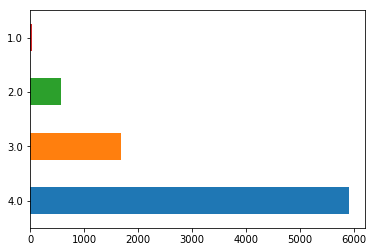

In [161]:
data[data.isFraud == 1].oldBalanceQtl.value_counts().plot(kind='barh')

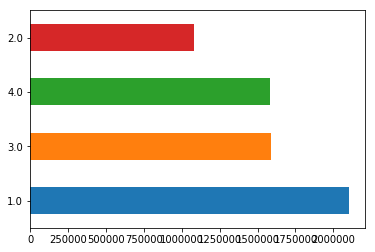

In [162]:
data[data.isFraud == 0].oldBalanceQtl.value_counts().plot(kind='barh')

In [163]:
#sns.barplot(x='isFraud', y='oldBalanceQtl', data=data)

In [164]:
data_new = data

In [165]:
data_new.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,...,CtoC,zeroAmount,origBalanceMatch,destBalanceMatch,amount75k+,day,hour,transferPercent,transferAll,oldBalanceQtl
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,...,0,0,0,-9839,0,0,1,0.0578,0,4.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,...,0,0,0,-1864,0,0,1,0.0877,0,3.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,...,1,0,0,-181,0,0,1,1.0000,1,2.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,...,1,0,0,21001,0,0,1,1.0000,1,2.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,...,0,0,0,-11668,0,0,1,0.2808,0,3.0


In [166]:
# New additions after last evening's push

In [167]:
corrmap = data_new.corr()

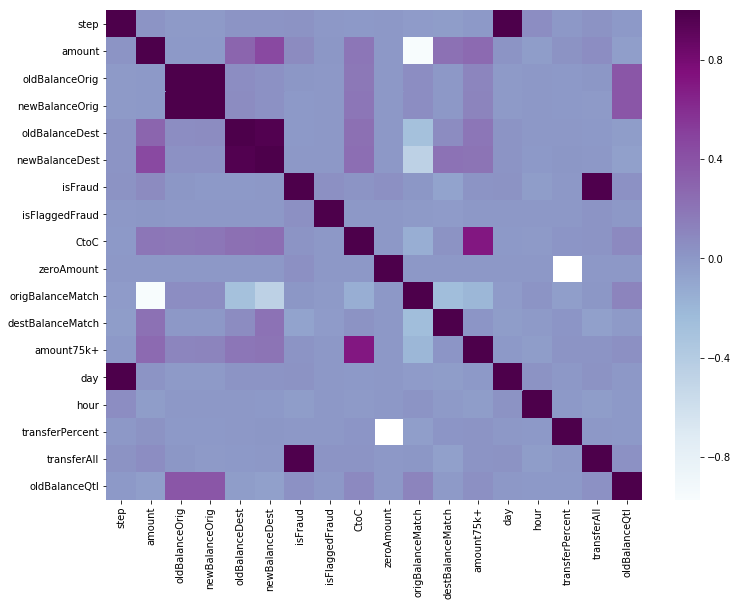

In [175]:
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmap, cmap='BuPu')
plt.show()

In [183]:
# Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pd.read_csv(url, names=names)


In [201]:
array =dataframe.values
X = array[:,0:8]
Y = array[:,8]
# feature extraction
test = SelectKBest(score_func=chi2, k=5)
fit = test.fit(X, Y)
fit

SelectKBest(k=5, score_func=<function chi2 at 0x1173df0d0>)

In [202]:

# summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)


[ 111.52  1411.887   17.605   53.108 2175.565  127.669    5.393  181.304]


In [190]:
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

[[148.    0.   33.6  50. ]
 [ 85.    0.   26.6  31. ]
 [183.    0.   23.3  32. ]
 [ 89.   94.   28.1  21. ]
 [137.  168.   43.1  33. ]]


In [169]:
# Future work for cleaning  
# how many of these are fraud, and find out the % of fraud cases and check if this is bad data, (part of the data was 
#incorrectly collected -- mislabled and find out how much of this dataset has such tendencies 

#do for ab and ba and delete the features. 
